<br>
<p><font size="6"><b>Correlação entre Compradores e Leads / <i>Correlation Between Buyers and Leads</i></b></font></p>
<br>
<p><font size="6"><b>Desafio de Ciência de Dados / <i>Data Science Challenge</i></b></font></p>
<br>
<p><font size="6"><b>Entrega / <i>Delivery</i>: Notebook</b></font></p>
<br>
<p><font size="6"><b>Desenvolvedor / <i>Developer</i>: Solano Jacon</b></font></p>
<br>

In [1]:
import psycopg2 # if necessary, install psycopg2-binary library, NOT psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle
import warnings
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

## Leitura dos dados e normalização / <i>Data reading and normalization</i>

### Conexão com a base de dados e leitura dos dados / <i>Database connection and data reading</i>

- forms.id_form (pkey) -> order_items.id_form (fkey)
- orders.id_pedido (pkey) -> order_items.id_pedido (fkey)

In [2]:
# conn = psycopg2.connect(database='database',
#                         host='host',
#                         user='user',
#                         password='password',
#                         port='port')

In [3]:
# sql = '''SELECT f.*, oi.id_pedido, oi.id
#          FROM forms AS f
#          LEFT OUTER JOIN order_items AS oi ON f.id_form=oi.id_form'''
# dados = pd.read_sql_query(sql, con=conn)

In [4]:
folder_data_files = 'data'

In [8]:
dados = pd.read_csv(folder_data_files + '/dados.csv', index_col=0, encoding='iso-8859-1')

In [9]:
dados.iloc[:, :9]

,id_form,id_cliente,data,sistema_operacional,navegador,localizacao,locale,cidade,estado
0,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
1,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
2,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
3,c7d453c9c01223a42968d9fe136047,d2620a3e6f00a6dc6e88,2022-01-03 15:42:22,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
4,72830da153824af486be15cd48b3f3,9a48802d8290d19471f3,2022-01-04 08:39:53,Windows,Chrome,"Ribeirão Preto, Sao Paulo",BR,RIBEIRÃO PRETO,SAO PAULO
...,...,...,...,...,...,...,...,...,...
585467,b52c38b852d68ec4b5c8f4fcdf2604,3e0f5c6131151b075a34,2022-02-26 21:28:12,iOS,NaN,"Santa Barbara, Bahia",BR,SANTA BARBARA,BAHIA
585468,df3bb506075aa2e212d9a0bf90975d,0266fbc12fe7e7487605,2022-03-03 18:01:43,Windows,Chrome,"Sao Pedro, Sao Paulo",BR,SAO PEDRO,SAO PAULO
585469,c172d08a3a36b903cd49f6af8da9c3,b6c0b82cc271fd1203fc,2022-01-27 18:09:34,Windows,Chrome,"Itatiba, Sao Paulo",BR,ITATIBA,SAO PAULO
585470,369f40f668082066838beec2861a40,47e6af54dc5898b49ec3,2022-01-27 18:52:16,Android,Chrome,"Arapoti, Parana",BR,ARAPOTI,PARANA


In [10]:
dados.iloc[:, 9:18]

,qtde_lavagem_semana,utm_source,tipo_cabelo,comprimento,tipo_fios,procedimentos,tempo_procedimento,dieta,atividade_fisica
0,4,NaN,Tipo 2,Raíz exposta,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente
1,4,NaN,Tipo 2,Raíz exposta,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente
2,4,NaN,Tipo 2,Raíz exposta,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente
3,4,NaN,Tipo 2,Raíz exposta,Pontas duplas,Nenhum,Há 2 semanas,Celíaca,Frequente
4,7,NaN,Tipo 4,Muito curto,Perfeitos,Todos acima,Há mais de 1 mês,Nenhuma restrição,Nunca
...,...,...,...,...,...,...,...,...,...
585467,4,linktree,Tipo 1,Muito curto,Rebeldes,Nenhum,Há 1 semana,Nenhuma restrição,Frequente
585468,1,NaN,Tipo 1,Raíz exposta,Pontas duplas,Tintura,Há 1 mês,Celíaca,Raramente
585469,7,NaN,Tipo 1,Muito curto,Perfeitos,Nenhum,Há mais de 1 mês,Nenhuma restrição,Sempre
585470,4,NaN,Tipo 1,Raíz exposta,Pontas duplas,Todos acima,Há mais de 1 mês,Nenhuma restrição,Sempre


In [11]:
dados.iloc[:, 18:]

,frequencia_estresse,caracteristica,faixa_etaria,efeitos_desejados,fragancia,id_pedido,id
0,Nunca,Característica 1,25 a 34,Efeito 7,Rosas,5d2301cb6bf9d7c,426190.0
1,Nunca,Característica 1,25 a 34,Efeito 7,Rosas,5d2301cb6bf9d7c,426189.0
2,Nunca,Característica 1,25 a 34,Efeito 7,Rosas,5d2301cb6bf9d7c,426188.0
3,Nunca,Característica 1,25 a 34,Efeito 7,Rosas,5d2301cb6bf9d7c,426187.0
4,Nunca,Característica 6,55 a 64,Efeito 1,Eucalipto,NaN,NaN
...,...,...,...,...,...,...,...
585467,Uma vez por mês,Característica 7,18 a 24,Efeito 7,Rosas,NaN,NaN
585468,Regularmente,Característica 9,65+,"Efeito 7, Efeito 1, Efeito 5",Flores do campo,NaN,NaN
585469,Nunca,Característica 6,55 a 64,Efeito 1,Eucalipto,NaN,NaN
585470,Nunca,Característica 8,18 a 24,"Efeito 7, Efeito 1, Efeito 5, Efeito 8",Eucalipto,NaN,NaN


In [12]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585472 entries, 0 to 585471
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id_form              585472 non-null  object 
 1   id_cliente           585472 non-null  object 
 2   data                 585472 non-null  object 
 3   sistema_operacional  585472 non-null  object 
 4   navegador            453493 non-null  object 
 5   localizacao          585472 non-null  object 
 6   locale               585472 non-null  object 
 7   cidade               565977 non-null  object 
 8   estado               585240 non-null  object 
 9   qtde_lavagem_semana  585472 non-null  int64  
 10  utm_source           509386 non-null  object 
 11  tipo_cabelo          585472 non-null  object 
 12  comprimento          585472 non-null  object 
 13  tipo_fios            585472 non-null  object 
 14  procedimentos        585472 non-null  object 
 15  tempo_procediment

In [13]:
dados.isna().sum()

id_form                     0
id_cliente                  0
data                        0
sistema_operacional         0
navegador              131979
localizacao                 0
locale                      0
cidade                  19495
estado                    232
qtde_lavagem_semana         0
utm_source              76086
tipo_cabelo                 0
comprimento                 0
tipo_fios                   0
procedimentos               0
tempo_procedimento          0
dieta                       0
atividade_fisica            0
frequencia_estresse         0
caracteristica              0
faixa_etaria                0
efeitos_desejados        1241
fragancia                   0
id_pedido              373809
id                     373809
dtype: int64

In [14]:
dados = dados.fillna(value=np.nan)

In [15]:
caracteres_especiais = ['\u014c', '\u014d', '\u0160', '\u0161']
caracteres_substitutos = ['O', 'o', 'S', 's']

for caractere_especial, caractere_substituto in zip(caracteres_especiais, caracteres_substitutos):
    dados.loc[dados['localizacao'].notna(), 'localizacao'] = dados.loc[dados['localizacao'].notna(), 'localizacao'].apply(lambda x: x.replace(caractere_especial, caractere_substituto))
    dados.loc[dados['cidade'].notna(), 'cidade'] = dados.loc[dados['cidade'].notna(), 'cidade'].apply(lambda x: x.replace(caractere_especial, caractere_substituto))
    dados.loc[dados['estado'].notna(), 'estado'] = dados.loc[dados['estado'].notna(), 'estado'].apply(lambda x: x.replace(caractere_especial, caractere_substituto))

In [16]:
# dados.to_csv(folder_data_files + '/dados.csv', encoding='iso-8859-1')

### Análise dos Dados / <i>Data Analysis</i>

In [17]:
dados['data'].min()

'2022-01-01 00:13:01'

In [18]:
dados['data'].max()

'2022-06-30 23:57:47'

In [19]:
dados['sistema_operacional'].value_counts(normalize=True, dropna=False)

Android      0.597637
iOS          0.330841
Windows      0.063573
Mac OS       0.005380
Linux        0.002193
 ChromeOS    0.000376
Name: sistema_operacional, dtype: float64

In [20]:
dados['navegador'].value_counts(normalize=True, dropna=False)

Chrome            0.658274
NaN               0.225423
Safari            0.101281
ChromeiOS         0.006603
ChromiumEdge      0.004099
Firefox           0.002856
Opera             0.001443
MSEdge            0.000012
Yandex.Browser    0.000009
Name: navegador, dtype: float64

In [21]:
dados['localizacao'].value_counts(normalize=True, dropna=False)

São Paulo, Sao Paulo              0.128623
Rio de Janeiro, Rio de Janeiro    0.045292
Belo Horizonte, Minas Gerais      0.025294
null, null                        0.023654
Brasília, Federal District        0.023260
                                    ...   
Lady Lake, Florida                0.000002
Aratuba, Ceara                    0.000002
Fanhoes, Lisbon                   0.000002
Elk River, Minnesota              0.000002
Cebu City, Central Visayas        0.000002
Name: localizacao, Length: 5679, dtype: float64

In [22]:
dados['locale'].value_counts(normalize=True, dropna=False)

BR    1.0
Name: locale, dtype: float64

In [23]:
dados['cidade'].value_counts(normalize=True, dropna=False)

SÃO PAULO         0.128623
RIO DE JANEIRO    0.045292
NaN               0.033298
BELO HORIZONTE    0.025318
BRASÍLIA          0.023260
                    ...   
BRIDGWATER        0.000002
ALTO BOA VISTA    0.000002
MIDDLEBORO        0.000002
TURKU             0.000002
CEBU CITY         0.000002
Name: cidade, Length: 5315, dtype: float64

In [24]:
dados['estado'].value_counts(normalize=True, dropna=False)

 SAO PAULO             0.324434
 MINAS GERAIS          0.089432
 RIO DE JANEIRO        0.084059
 PARANA                0.062290
 RIO GRANDE DO SUL     0.050686
                         ...   
 ORDINO                0.000002
 CASTILLE-LA MANCHA    0.000002
 BRATISLAVA            0.000002
 MOSTEIROS             0.000002
 CENTRAL VISAYAS       0.000002
Name: estado, Length: 328, dtype: float64

In [25]:
dados['qtde_lavagem_semana'].value_counts(normalize=True, dropna=False)

4    0.321218
1    0.267693
2    0.160269
6    0.082084
5    0.080099
3    0.053704
7    0.034932
Name: qtde_lavagem_semana, dtype: float64

In [26]:
dados['utm_source'].value_counts(normalize=True, dropna=False)

influencer         0.316890
facebook           0.206488
NaN                0.129957
google             0.086556
sf_wpp_camp        0.066584
linktree           0.053991
instagram          0.046786
sf_email_camp      0.036611
sf_wpp_flux        0.025072
rakuten            0.008084
IGShopping         0.007879
email_sf           0.003964
blog               0.003013
tiktok             0.001933
microinfluencer    0.001732
adwords            0.001578
site               0.001370
sf_email_flux      0.000905
meliuz             0.000167
incicacao          0.000130
salesforce         0.000114
whatsapp           0.000050
telegram           0.000032
sendinblue         0.000032
sf_sms_camp        0.000017
cpc                0.000012
sf_wpp_flu         0.000012
teste_source       0.000007
sms                0.000007
facebook           0.000005
uaubox             0.000003
popup              0.000003
sf_camp_email      0.000003
email              0.000002
Facebook ads       0.000002
santander          0

In [27]:
dados['tipo_cabelo'].value_counts(normalize=True, dropna=False)

Tipo 1    0.421457
Tipo 2    0.364034
Tipo 4    0.173897
Tipo 3    0.040612
Name: tipo_cabelo, dtype: float64

In [28]:
dados['comprimento'].value_counts(normalize=True, dropna=False)

Muito curto     0.472550
Raíz exposta    0.356700
Longo           0.123586
Extra longo     0.047164
Name: comprimento, dtype: float64

In [29]:
dados['tipo_fios'].value_counts(normalize=True, dropna=False)

Secos            0.570929
Pontas duplas    0.169395
Rebeldes         0.167234
Perfeitos        0.092442
Name: tipo_fios, dtype: float64

In [30]:
dados['procedimentos'].value_counts(normalize=True, dropna=False)

Corte agressivo                                       0.182757
Todos acima                                           0.153710
Tintura                                               0.086262
Exposição ao sol                                      0.081025
Tintura, Corte agressivo                              0.076801
                                                        ...   
Nenhum, Tintura, Exposição ao sol, Corte agressivo    0.000323
Exposição ao sol, Tintura, Nenhum                     0.000314
Exposição ao sol, Corte agressivo, Nenhum, Tintura    0.000280
Exposição ao sol, Tintura, Nenhum, Corte agressivo    0.000203
N/C                                                   0.000010
Name: procedimentos, Length: 66, dtype: float64

In [31]:
dados['tempo_procedimento'].value_counts(normalize=True, dropna=False)

Há 2 semanas               0.331857
Há 1 semana                0.272761
Há mais de 1 mês           0.185780
Há 1 mês                   0.116562
Não houve procedimentos    0.093039
Name: tempo_procedimento, dtype: float64

In [32]:
dados['dieta'].value_counts(normalize=True, dropna=False)

Celíaca                  0.719338
Nenhuma restrição        0.218648
Intolerante a lactose    0.044089
Leve                     0.017926
Name: dieta, dtype: float64

In [33]:
dados['atividade_fisica'].value_counts(normalize=True, dropna=False)

Raramente    0.524749
Frequente    0.283120
Sempre       0.094459
N/C          0.084467
Nunca        0.013205
Name: atividade_fisica, dtype: float64

In [34]:
dados['frequencia_estresse'].value_counts(normalize=True, dropna=False)

Uma vez por mês    0.524146
Nunca              0.410898
Regularmente       0.060179
Quase sempre       0.004777
Name: frequencia_estresse, dtype: float64

In [35]:
dados['caracteristica'].value_counts(normalize=True, dropna=False)

Característica 3                                                                                               0.268011
Característica 7                                                                                               0.103595
Característica 1                                                                                               0.093536
Característica 3, Característica 8                                                                             0.085174
Característica 2                                                                                               0.040010
                                                                                                                 ...   
Característica 3, Característica 1, Característica 9, Característica 8, Característica 4, Característica 10    0.000002
Característica 8, Característica 3, Característica 10, Característica 1, Característica 9, Característica 4    0.000002
Característica 6, Característica 1, Cara

In [36]:
dados['faixa_etaria'].value_counts(normalize=True, dropna=False)

25 a 34    0.368976
18 a 24    0.269557
35 a 44    0.190400
45 a 54    0.068461
11 a 17    0.067578
55 a 64    0.021719
2 a 10     0.007476
65+        0.005833
Name: faixa_etaria, dtype: float64

In [37]:
dados['efeitos_desejados'].value_counts(normalize=True, dropna=False)

Efeito 6, Efeito 7, Efeito 4, Efeito 3               0.014785
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     0.014747
Efeito 6, Efeito 7, Efeito 8, Efeito 4               0.012257
Efeito 7                                             0.010769
Efeito 6, Efeito 2, Efeito 4, Efeito 3               0.009478
                                                       ...   
Efeito 3, Efeito 8, Efeito 1, Efeito 4, Efeito 7     0.000002
Efeito 1, Efeito 8, Efeito 3, Efeito 4, Efeito 5     0.000002
Efeito 4, Efeito 10, Efeito 2, Efeito 7, Efeito 1    0.000002
Efeito 10, Efeito 3, Efeito 2, Efeito 4, Efeito 1    0.000002
Efeito 8, Efeito 4, Efeito 10, Efeito 2, Efeito 7    0.000002
Name: efeitos_desejados, Length: 11836, dtype: float64

In [38]:
dados['fragancia'].value_counts(normalize=True, dropna=False)

Rosas              0.522672
Eucalipto          0.380327
Flores do campo    0.097000
Name: fragancia, dtype: float64

### Preparação e Análise dos Dados Alvo / <i>Target Data Preparation and Analysis</i>

In [39]:
dados['pedido'] = 0
dados.loc[dados['id_pedido'].notna(), 'pedido'] = 1

In [40]:
dados['pedido'].value_counts(normalize=True, dropna=False)

0    0.638475
1    0.361525
Name: pedido, dtype: float64

### Definição dos Próximos Passos / <i>Definition of Next Steps</i>

Criação de features:
- tempo_procedimento: transformação do conteúdo de categorias ordinais de texto para categorias ordinais numéricas
- faixa_etaria: transformação do conteúdo de categorias ordinais de texto para categorias ordinais numéricas
- procedimentos: separação do conteúdo de categorias em colunas binárias para cada categoria
- caracteristica: separação do conteúdo de categorias em colunas binárias para cada categoria
- efeitos_desejados: separação do conteúdo de categorias em colunas binárias para cada categoria

<i>Feature creation</i>:
<i>
- tempo_procedimento: transforming content from ordinal text categories to numeric ordinal categories
- faixa_etaria: transforming content from ordinal text categories to numeric ordinal categories
- procedimentos: separation of categories content into binary columns for each category
- caracteristica: separation of categories content into binary columns for each category
- efeitos_desejados: separation of categories content into binary columns for each category
</i>

Encoding:
- sistema_operacional
- estado
- utm_source
- tipo_cabelo
- comprimento
- tipo_fios
- dieta
- atividade_fisica
- frequencia_estresse

Scaling:
- qtde_lavagem_semana

### Criação de Features / <i>Feature Creation</i>

<b>tempo_procedimento</b>

In [41]:
dados['tempo_procedimento'].value_counts(normalize=True, dropna=False)

Há 2 semanas               0.331857
Há 1 semana                0.272761
Há mais de 1 mês           0.185780
Há 1 mês                   0.116562
Não houve procedimentos    0.093039
Name: tempo_procedimento, dtype: float64

In [42]:
dados.loc[dados['tempo_procedimento']=='Não houve procedimentos', 'tempo_procedimento_quantificado'] = 0
dados.loc[dados['tempo_procedimento']=='Há 1 semana', 'tempo_procedimento_quantificado'] = 1
dados.loc[dados['tempo_procedimento']=='Há 2 semanas', 'tempo_procedimento_quantificado'] = 2
dados.loc[dados['tempo_procedimento']=='Há 1 mês', 'tempo_procedimento_quantificado'] = 3
dados.loc[dados['tempo_procedimento']=='Há mais de 1 mês', 'tempo_procedimento_quantificado'] = 4

In [43]:
dados['tempo_procedimento_quantificado'].value_counts(normalize=True, dropna=False)

2.0    0.331857
1.0    0.272761
4.0    0.185780
3.0    0.116562
0.0    0.093039
Name: tempo_procedimento_quantificado, dtype: float64

<b>faixa_etaria</b>

In [44]:
dados['faixa_etaria'].value_counts(normalize=True, dropna=False)

25 a 34    0.368976
18 a 24    0.269557
35 a 44    0.190400
45 a 54    0.068461
11 a 17    0.067578
55 a 64    0.021719
2 a 10     0.007476
65+        0.005833
Name: faixa_etaria, dtype: float64

In [45]:
dados.loc[dados['faixa_etaria']=='2 a 10', 'faixa_etaria_quantificado'] = 1
dados.loc[dados['faixa_etaria']=='11 a 17', 'faixa_etaria_quantificado'] = 2
dados.loc[dados['faixa_etaria']=='18 a 24', 'faixa_etaria_quantificado'] = 3
dados.loc[dados['faixa_etaria']=='25 a 34', 'faixa_etaria_quantificado'] = 4
dados.loc[dados['faixa_etaria']=='35 a 44', 'faixa_etaria_quantificado'] = 5
dados.loc[dados['faixa_etaria']=='45 a 54', 'faixa_etaria_quantificado'] = 6
dados.loc[dados['faixa_etaria']=='55 a 64', 'faixa_etaria_quantificado'] = 7
dados.loc[dados['faixa_etaria']=='65+', 'faixa_etaria_quantificado'] = 8

In [46]:
dados['faixa_etaria_quantificado'].value_counts(normalize=True, dropna=False)

4.0    0.368976
3.0    0.269557
5.0    0.190400
6.0    0.068461
2.0    0.067578
7.0    0.021719
1.0    0.007476
8.0    0.005833
Name: faixa_etaria_quantificado, dtype: float64

<b>procedimentos</b>

In [47]:
dados['procedimentos'].value_counts(normalize=True, dropna=False)

Corte agressivo                                       0.182757
Todos acima                                           0.153710
Tintura                                               0.086262
Exposição ao sol                                      0.081025
Tintura, Corte agressivo                              0.076801
                                                        ...   
Nenhum, Tintura, Exposição ao sol, Corte agressivo    0.000323
Exposição ao sol, Tintura, Nenhum                     0.000314
Exposição ao sol, Corte agressivo, Nenhum, Tintura    0.000280
Exposição ao sol, Tintura, Nenhum, Corte agressivo    0.000203
N/C                                                   0.000010
Name: procedimentos, Length: 66, dtype: float64

In [48]:
procedimentos = ['Corte agressivo', 'Exposição ao sol', 'Nenhum', 'N/C', 'Tintura', 'Todos acima']

for procedimento in procedimentos:
    dados['procedimento ' + procedimento] = dados['procedimentos'].apply(lambda x: 1 if procedimento in x else 0)

In [49]:
dados['procedimentos']

0                            Nenhum
1                            Nenhum
2                            Nenhum
3                            Nenhum
4                       Todos acima
                    ...            
585467                       Nenhum
585468                      Tintura
585469                       Nenhum
585470                  Todos acima
585471    Exposição ao sol, Tintura
Name: procedimentos, Length: 585472, dtype: object

In [50]:
dados.iloc[:, -6:]

,procedimento Corte agressivo,procedimento Exposição ao sol,procedimento Nenhum,procedimento N/C,procedimento Tintura,procedimento Todos acima
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
585467,0,0,1,0,0,0
585468,0,0,0,0,1,0
585469,0,0,1,0,0,0
585470,0,0,0,0,0,1


<b>caracteristica</b>

In [51]:
dados['caracteristica'].value_counts(normalize=True, dropna=False)

Característica 3                                                                                               0.268011
Característica 7                                                                                               0.103595
Característica 1                                                                                               0.093536
Característica 3, Característica 8                                                                             0.085174
Característica 2                                                                                               0.040010
                                                                                                                 ...   
Característica 3, Característica 1, Característica 9, Característica 8, Característica 4, Característica 10    0.000002
Característica 8, Característica 3, Característica 10, Característica 1, Característica 9, Característica 4    0.000002
Característica 6, Característica 1, Cara

In [52]:
# A coluna caracteristica contém 10 categorias de 1 a 10 no formato "Característica 5"
# The column caracteristica contains 10 categories from 1 to 10 in the "Característica 5" format

for numero_caracteristica in range(1, 11):
    dados['caracteristica ' + str(numero_caracteristica)] = dados['caracteristica'].apply(lambda x: 1 if ('Característica ' + str(numero_caracteristica)) in x else 0)

In [53]:
dados['caracteristica']

0         Característica 1
1         Característica 1
2         Característica 1
3         Característica 1
4         Característica 6
                ...       
585467    Característica 7
585468    Característica 9
585469    Característica 6
585470    Característica 8
585471    Característica 2
Name: caracteristica, Length: 585472, dtype: object

In [54]:
dados.iloc[:, -10:]

,caracteristica 1,caracteristica 2,caracteristica 3,caracteristica 4,caracteristica 5,caracteristica 6,caracteristica 7,caracteristica 8,caracteristica 9,caracteristica 10
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
585467,0,0,0,0,0,0,1,0,0,0
585468,0,0,0,0,0,0,0,0,1,0
585469,0,0,0,0,0,1,0,0,0,0
585470,0,0,0,0,0,0,0,1,0,0


<b>efeitos_desejados</b>

In [55]:
dados['efeitos_desejados'].value_counts(normalize=True, dropna=False)

Efeito 6, Efeito 7, Efeito 4, Efeito 3               0.014785
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     0.014747
Efeito 6, Efeito 7, Efeito 8, Efeito 4               0.012257
Efeito 7                                             0.010769
Efeito 6, Efeito 2, Efeito 4, Efeito 3               0.009478
                                                       ...   
Efeito 3, Efeito 8, Efeito 1, Efeito 4, Efeito 7     0.000002
Efeito 1, Efeito 8, Efeito 3, Efeito 4, Efeito 5     0.000002
Efeito 4, Efeito 10, Efeito 2, Efeito 7, Efeito 1    0.000002
Efeito 10, Efeito 3, Efeito 2, Efeito 4, Efeito 1    0.000002
Efeito 8, Efeito 4, Efeito 10, Efeito 2, Efeito 7    0.000002
Name: efeitos_desejados, Length: 11836, dtype: float64

In [56]:
# A coluna efeitos_desejados contém 10 categorias de 1 a 10 no formato "Efeito 5"
# The column efeitos_desejados contains 10 categories from 1 to 10 in the "Efeito 5" format

dados['efeitos_desejados_modificado'] = dados['efeitos_desejados'].fillna(value='Nenhum')

for numero_efeito in range(1, 11):
    dados['efeitos_desejados ' + str(numero_efeito)] = dados['efeitos_desejados_modificado'].apply(lambda x: 1 if ('Efeito ' + str(numero_efeito)) in x else 0)

In [57]:
dados['efeitos_desejados']

0                                       Efeito 7
1                                       Efeito 7
2                                       Efeito 7
3                                       Efeito 7
4                                       Efeito 1
                           ...                  
585467                                  Efeito 7
585468              Efeito 7, Efeito 1, Efeito 5
585469                                  Efeito 1
585470    Efeito 7, Efeito 1, Efeito 5, Efeito 8
585471                                  Efeito 8
Name: efeitos_desejados, Length: 585472, dtype: object

In [58]:
dados.iloc[:, -10:]

,efeitos_desejados 1,efeitos_desejados 2,efeitos_desejados 3,efeitos_desejados 4,efeitos_desejados 5,efeitos_desejados 6,efeitos_desejados 7,efeitos_desejados 8,efeitos_desejados 9,efeitos_desejados 10
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
585467,0,0,0,0,0,0,1,0,0,0
585468,1,0,0,0,1,0,1,0,0,0
585469,1,0,0,0,0,0,0,0,0,0
585470,1,0,0,0,1,0,1,1,0,0


### Encoding

<b>sistema_operacional</b>

In [59]:
dados['sistema_operacional'].unique()

array(['iOS', 'Windows', 'Android', 'Mac OS', 'Linux', ' ChromeOS'],
      dtype=object)

In [60]:
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(dados[['sistema_operacional']])
dados['sistema_operacional_e_' + ohe.categories_[0]] = column_encoded

In [61]:
ohe.categories_

[array([' ChromeOS', 'Android', 'Linux', 'Mac OS', 'Windows', 'iOS'],
       dtype=object)]

In [62]:
dados.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       'utm_source', 'tipo_cabelo', 'comprimento', 'tipo_fios',
       'procedimentos', 'tempo_procedimento', 'dieta', 'atividade_fisica',
       'frequencia_estresse', 'caracteristica', 'faixa_etaria',
       'efeitos_desejados', 'fragancia', 'id_pedido', 'id', 'pedido',
       'tempo_procedimento_quantificado', 'faixa_etaria_quantificado',
       'procedimento Corte agressivo', 'procedimento Exposição ao sol',
       'procedimento Nenhum', 'procedimento N/C', 'procedimento Tintura',
       'procedimento Todos acima', 'caracteristica 1', 'caracteristica 2',
       'caracteristica 3', 'caracteristica 4', 'caracteristica 5',
       'caracteristica 6', 'caracteristica 7', 'caracteristica 8',
       'caracteristica 9', 'caracteristica 10', 'efeitos_desejados_modificado',
       'efeitos_desejados 1', 'efeitos_desejados 2', 'efeitos_desejado

<b>estado</b>

In [63]:
dados['estado'].unique()

array([' SAO PAULO', ' ENGLAND', ' SANTA CATARINA', ' ALAGOAS', ' CEARA',
       ' BAHIA', ' PIAUI', ' QUEBEC', ' PARANA', ' AMAZONAS', ' NULL',
       ' RIO DE JANEIRO', ' PERNAMBUCO', ' MATO GROSSO', ' MINAS GERAIS',
       ' TOCANTINS', ' PARA', ' RIO GRANDE DO SUL',
       ' RIO GRANDE DO NORTE', ' GOIAS', ' VIRGINIA', ' FEDERAL DISTRICT',
       ' RONDONIA', ' SERGIPE', ' MARANHAO', ' AMAPA', ' PARAÍBA',
       ' TEXAS', ' ESPIRITO SANTO', " PROVENCE-ALPES-CÔTE D'AZUR",
       ' MATO GROSSO DO SUL', ' RORAIMA', ' DEPARTAMENTO DE CAAGUAZU',
       ' ACRE', ' PORTO', ' DEPARTAMENTO DE MISIONES',
       ' NORTH RHINE-WESTPHALIA', ' NEW YORK', ' CONNECTICUT', ' LEIRIA',
       ' LISBON', ' BRITISH COLUMBIA', ' SANTIAGO METROPOLITAN',
       ' MADRID', ' FLANDERS', ' APULIA', ' AICHI', ' BASQUE COUNTRY',
       ' OHIO', ' DEPARTAMENTO DEL MAGDALENA', ' BRAGA',
       ' DEPARTAMENTO DEL ALTO PARANA', ' GIZA', ' WISCONSIN', ' ÉVORA',
       ' VIANA DO CASTELO', ' CASTELO BRANCO', ' DEPAR

In [64]:
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(dados[['estado']].replace(np.nan, 'Nenhum'))
dados['estado_e_' + ohe.categories_[0]] = column_encoded

In [65]:
ohe.categories_

[array([' AARGAU', ' ABRUZZO', ' ABU DHABI', ' ACRE', ' AICHI',
        ' AL ASIMAH', ' ALABAMA', ' ALAGOAS', ' ALBERTA', ' AMAPA',
        ' AMAZONAS', ' ANDALUSIA', ' ANTIOQUIA', ' APULIA', ' ARAGON',
        ' ARIZONA', ' ASUNCION', ' ATLÁNTICO', ' ATTICA', ' AUCKLAND',
        ' AUVERGNE-RHONE-ALPES', ' AVEIRO', ' AZORES',
        ' BADEN-WÜRTTEMBERG', ' BAFATA', ' BAHIA', ' BAJA CALIFORNIA',
        ' BALADIYAT AD DAWHAH', ' BALEARIC ISLANDS', ' BARANYA',
        ' BASQUE COUNTRY', ' BAVARIA', ' BEJA', ' BERN', ' BICOL',
        ' BOGOTA D.C.', ' BRAGA', ' BRAGANÇA', ' BRATISLAVA',
        ' BRITISH COLUMBIA', ' BRITTANY', ' BRUSSELS CAPITAL', ' BUDAPEST',
        ' BUENOS AIRES', ' BUENOS AIRES F.D.', ' CAJAMARCA', ' CALABRIA',
        ' CALIFORNIA', ' CAMPANIA', ' CANARY ISLANDS', ' CANELONES',
        ' CANTERBURY', ' CAPITAL REGION', ' CARABOBO', ' CASTELO BRANCO',
        ' CASTILLE AND LEÓN', ' CASTILLE-LA MANCHA', ' CATALONIA',
        ' CEARA', ' CENTRAL JUTLAND', ' CENTRA

In [66]:
dados.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'estado_e_ WESTERN AUSTRALIA', 'estado_e_ WISCONSIN',
       'estado_e_ YUCATÁN', 'estado_e_ ZEELAND', 'estado_e_ ZULIA',
       'estado_e_ ZURICH', 'estado_e_ ÉVORA', 'estado_e_ ÎLE-DE-FRANCE',
       'estado_e_ ÑUBLE', 'estado_e_Nenhum'],
      dtype='object', length=389)

<b>utm_source</b>

In [67]:
dados['utm_source'].unique()

array([nan, 'facebook', 'linktree', 'influencer', 'IGShopping', 'tiktok',
       'sf_wpp_flux', 'google', 'instagram', 'incicacao', 'sf_wpp_camp',
       'sf_email_camp', 'adwords', 'sf_email_flux', 'site',
       'Facebook ads ', 'microinfluencer', 'meliuz', 'sms', 'whatsapp',
       'sendinblue', 'telegram', 'salesforce', 'email', 'rakuten', 'cpc',
       'sf_wpp_flu', 'copy_link', 'email_sf', 'blog', 'facebook ',
       'sf_sms_camp', 'santander', 'all', 'uaubox', 'teste_source',
       'popup', 'sf_camp_email', 'sf_'], dtype=object)

In [68]:
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(dados[['utm_source']].replace(np.nan, 'Nenhum'))
dados['utm_source_e_' + ohe.categories_[0]] = column_encoded

In [69]:
ohe.categories_

[array(['Facebook ads ', 'IGShopping', 'Nenhum', 'adwords', 'all', 'blog',
        'copy_link', 'cpc', 'email', 'email_sf', 'facebook', 'facebook ',
        'google', 'incicacao', 'influencer', 'instagram', 'linktree',
        'meliuz', 'microinfluencer', 'popup', 'rakuten', 'salesforce',
        'santander', 'sendinblue', 'sf_', 'sf_camp_email', 'sf_email_camp',
        'sf_email_flux', 'sf_sms_camp', 'sf_wpp_camp', 'sf_wpp_flu',
        'sf_wpp_flux', 'site', 'sms', 'telegram', 'teste_source', 'tiktok',
        'uaubox', 'whatsapp'], dtype=object)]

In [70]:
dados.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'utm_source_e_sf_wpp_camp', 'utm_source_e_sf_wpp_flu',
       'utm_source_e_sf_wpp_flux', 'utm_source_e_site', 'utm_source_e_sms',
       'utm_source_e_telegram', 'utm_source_e_teste_source',
       'utm_source_e_tiktok', 'utm_source_e_uaubox', 'utm_source_e_whatsapp'],
      dtype='object', length=428)

<b>tipo_cabelo</b>

In [71]:
dados['tipo_cabelo'].unique()

array(['Tipo 2', 'Tipo 4', 'Tipo 1', 'Tipo 3'], dtype=object)

In [72]:
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(dados[['tipo_cabelo']])
dados['tipo_cabelo_e_' + ohe.categories_[0]] = column_encoded

In [73]:
ohe.categories_

[array(['Tipo 1', 'Tipo 2', 'Tipo 3', 'Tipo 4'], dtype=object)]

In [74]:
dados.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'utm_source_e_sms', 'utm_source_e_telegram',
       'utm_source_e_teste_source', 'utm_source_e_tiktok',
       'utm_source_e_uaubox', 'utm_source_e_whatsapp', 'tipo_cabelo_e_Tipo 1',
       'tipo_cabelo_e_Tipo 2', 'tipo_cabelo_e_Tipo 3', 'tipo_cabelo_e_Tipo 4'],
      dtype='object', length=432)

<b>comprimento</b>

In [75]:
dados['comprimento'].unique()

array(['Raíz exposta', 'Muito curto', 'Extra longo', 'Longo'],
      dtype=object)

In [76]:
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(dados[['comprimento']])
dados['comprimento_e_' + ohe.categories_[0]] = column_encoded

In [77]:
ohe.categories_

[array(['Extra longo', 'Longo', 'Muito curto', 'Raíz exposta'],
       dtype=object)]

In [78]:
dados.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'utm_source_e_uaubox', 'utm_source_e_whatsapp', 'tipo_cabelo_e_Tipo 1',
       'tipo_cabelo_e_Tipo 2', 'tipo_cabelo_e_Tipo 3', 'tipo_cabelo_e_Tipo 4',
       'comprimento_e_Extra longo', 'comprimento_e_Longo',
       'comprimento_e_Muito curto', 'comprimento_e_Raíz exposta'],
      dtype='object', length=436)

<b>tipo_fios</b>

In [79]:
dados['tipo_fios'].unique()

array(['Pontas duplas', 'Perfeitos', 'Rebeldes', 'Secos'], dtype=object)

In [80]:
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(dados[['tipo_fios']])
dados['tipo_fios_e_' + ohe.categories_[0]] = column_encoded

In [81]:
ohe.categories_

[array(['Perfeitos', 'Pontas duplas', 'Rebeldes', 'Secos'], dtype=object)]

In [82]:
dados.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'tipo_cabelo_e_Tipo 3', 'tipo_cabelo_e_Tipo 4',
       'comprimento_e_Extra longo', 'comprimento_e_Longo',
       'comprimento_e_Muito curto', 'comprimento_e_Raíz exposta',
       'tipo_fios_e_Perfeitos', 'tipo_fios_e_Pontas duplas',
       'tipo_fios_e_Rebeldes', 'tipo_fios_e_Secos'],
      dtype='object', length=440)

<b>dieta</b>

In [83]:
dados['dieta'].unique()

array(['Celíaca', 'Nenhuma restrição', 'Intolerante a lactose', 'Leve'],
      dtype=object)

In [84]:
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(dados[['dieta']])
dados['dieta_e_' + ohe.categories_[0]] = column_encoded

In [85]:
ohe.categories_

[array(['Celíaca', 'Intolerante a lactose', 'Leve', 'Nenhuma restrição'],
       dtype=object)]

In [86]:
dados.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'comprimento_e_Muito curto', 'comprimento_e_Raíz exposta',
       'tipo_fios_e_Perfeitos', 'tipo_fios_e_Pontas duplas',
       'tipo_fios_e_Rebeldes', 'tipo_fios_e_Secos', 'dieta_e_Celíaca',
       'dieta_e_Intolerante a lactose', 'dieta_e_Leve',
       'dieta_e_Nenhuma restrição'],
      dtype='object', length=444)

<b>atividade_fisica</b>

In [87]:
dados['atividade_fisica'].unique()

array(['Frequente', 'Nunca', 'Raramente', 'Sempre', 'N/C'], dtype=object)

In [88]:
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(dados[['atividade_fisica']])
dados['atividade_fisica_e_' + ohe.categories_[0]] = column_encoded

In [89]:
ohe.categories_

[array(['Frequente', 'N/C', 'Nunca', 'Raramente', 'Sempre'], dtype=object)]

In [90]:
dados.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'tipo_fios_e_Secos', 'dieta_e_Celíaca', 'dieta_e_Intolerante a lactose',
       'dieta_e_Leve', 'dieta_e_Nenhuma restrição',
       'atividade_fisica_e_Frequente', 'atividade_fisica_e_N/C',
       'atividade_fisica_e_Nunca', 'atividade_fisica_e_Raramente',
       'atividade_fisica_e_Sempre'],
      dtype='object', length=449)

<b>frequencia_estresse</b>

In [91]:
dados['frequencia_estresse'].unique()

array(['Nunca', 'Regularmente', 'Quase sempre', 'Uma vez por mês'],
      dtype=object)

In [92]:
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(dados[['frequencia_estresse']])
dados['frequencia_estresse_e_' + ohe.categories_[0]] = column_encoded

In [93]:
ohe.categories_

[array(['Nunca', 'Quase sempre', 'Regularmente', 'Uma vez por mês'],
       dtype=object)]

In [94]:
dados.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'dieta_e_Nenhuma restrição', 'atividade_fisica_e_Frequente',
       'atividade_fisica_e_N/C', 'atividade_fisica_e_Nunca',
       'atividade_fisica_e_Raramente', 'atividade_fisica_e_Sempre',
       'frequencia_estresse_e_Nunca', 'frequencia_estresse_e_Quase sempre',
       'frequencia_estresse_e_Regularmente',
       'frequencia_estresse_e_Uma vez por mês'],
      dtype='object', length=453)

### Scaling

<b>qtde_lavagem_semana</b>

In [95]:
mms = MinMaxScaler()
mms.fit(dados[['qtde_lavagem_semana']])
dados['qtde_lavagem_semana_std'] = mms.transform(dados[['qtde_lavagem_semana']])
dados[['qtde_lavagem_semana', 'qtde_lavagem_semana_std']]

,qtde_lavagem_semana,qtde_lavagem_semana_std
0,4,0.500000
1,4,0.500000
2,4,0.500000
3,4,0.500000
4,7,1.000000
...,...,...
585467,4,0.500000
585468,1,0.000000
585469,7,1.000000
585470,4,0.500000


## Separação de bases para treinar e efetuar o crossvalidation / <i>Separation of bases for training and crossvalidation</i>

### Separação de uma amostra dos dados para avaliação dos modelos / <i>Separation of a sample of data for evaluation of models</i>

In [96]:
dados_amostra = dados.sample(frac=0.02, random_state=42)

X = dados_amostra.drop(columns=['id_form', 'id_cliente', 'data', 'navegador', 'localizacao', 'locale', 'cidade', 'fragancia', 'id_pedido', 'id', \
                                'tempo_procedimento', 'faixa_etaria', 'procedimentos', 'caracteristica', 'efeitos_desejados', 'efeitos_desejados_modificado', \
                                'sistema_operacional', 'estado', 'utm_source', 'tipo_cabelo', 'comprimento', 'tipo_fios', 'dieta', 'atividade_fisica', 'frequencia_estresse', \
                                'qtde_lavagem_semana', \
                                'pedido'])

y = dados_amostra['pedido']

### Análise de desempenho de vários modelos com sua configuração padrão / <i>Performance analysis of various models with their default configuration</i>

In [97]:
model = DummyClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.64
Precision = 0.0
Recall = 0.0
F1 score = 0.0


In [98]:
model = LogisticRegression(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.66
Precision = 0.56
Recall = 0.24
F1 score = 0.33


In [99]:
model = KNeighborsClassifier()
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.6
Precision = 0.42
Recall = 0.3
F1 score = 0.35


In [100]:
model = SGDClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.61
Precision = 0.57
Recall = 0.23
F1 score = 0.21


In [101]:
model = SVC(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.65
Precision = 0.63
Recall = 0.06
F1 score = 0.11


In [102]:
model = DecisionTreeClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.58
Precision = 0.42
Recall = 0.44
F1 score = 0.43


In [103]:
model = RandomForestClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.66
Precision = 0.6
Recall = 0.16
F1 score = 0.25


In [104]:
model = AdaBoostClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.65
Precision = 0.54
Recall = 0.24
F1 score = 0.34


In [105]:
model = GradientBoostingClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.65
Precision = 0.56
Recall = 0.17
F1 score = 0.27


In [106]:
model = XGBClassifier(verbosity=0, random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.65
Precision = 0.55
Recall = 0.17
F1 score = 0.26


### Separação dos dados em dados para treino e dados para teste para avaliação do modelo escolhido / <i>Separation of data into training data and test data for evaluation of the chosen model</i>

In [107]:
X = dados.drop(columns=['id_form', 'id_cliente', 'data', 'navegador', 'localizacao', 'locale', 'cidade', 'fragancia', 'id_pedido', 'id', \
                        'tempo_procedimento', 'faixa_etaria', 'procedimentos', 'caracteristica', 'efeitos_desejados', 'efeitos_desejados_modificado', \
                        'sistema_operacional', 'estado', 'utm_source', 'tipo_cabelo', 'comprimento', 'tipo_fios', 'dieta', 'atividade_fisica', 'frequencia_estresse', \
                        'qtde_lavagem_semana', \
                        'pedido'])

y = dados['pedido']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Análise de desempenho do modelo escolhido com sua configuração padrão / <i>Performance analysis of the chosen model with its default configuration</i>

In [108]:
%%time

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred=y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89    112064
           1       0.75      0.95      0.84     63578

    accuracy                           0.87    175642
   macro avg       0.86      0.89      0.86    175642
weighted avg       0.89      0.87      0.87    175642

CPU times: user 20.7 s, sys: 417 ms, total: 21.1 s
Wall time: 21 s


In [109]:
confusion_matrix(y_true=y_test, y_pred=y_pred_test)

array([[91688, 20376],
       [ 2873, 60705]])

### Análise de desempenho do modelo escolhido com balanceamento de classes do dado alvo a ser predito / <i>Performance analysis of the chosen model with class balancing of the target data to be predicted</i>

In [110]:
# BLOCOS ABAIXO COMENTADOS PELA DEMORA NA EXECUÇÃO E ALTO CONSUMO DE MEMÓRIA SEM AGREGAR AUMENTO DE PERFORMANCE PARA O MODELO
# BLOCKS BELOW COMMENTATED BY THE DELAY IN EXECUTION AND HIGH MEMORY CONSUMPTION WITHOUT ADDING INCREASE IN PERFORMANCE TO THE MODEL

In [111]:
# %%time

# sm = SMOTE(random_state=42)
# X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [112]:
# %%time

# model = DecisionTreeClassifier(random_state=42)
# model.fit(X_train_smote, y_train_smote)
# y_pred_test = model.predict(X_test)
# y_pred_proba_test = model.predict_proba(X_test)

# print(classification_report(y_true=y_test, y_pred=y_pred_test))

In [113]:
# confusion_matrix(y_true=y_test, y_pred=y_pred_test)

### Otimização do modelo escolhido baseado em ajuste de hiperparâmetros / <i>Optimization of the chosen model based on hyperparameter tuning</i>

In [114]:
# BLOCOS ABAIXO COMENTADOS PELO ALTO CONSUMO DE MEMÓRIA
# BLOCKS BELOW COMMENTATED BY HIGH MEMORY CONSUMPTION

In [115]:
# %%time

# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [2, 4, 6, 8, 10, 12, None],
#     'random_state': [42]
# }

# model = DecisionTreeClassifier()
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

In [116]:
# grid_search.best_params_

In [117]:
# model = grid_search.best_estimator_
model = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     94745
           1       0.95      0.75      0.84     80897

    accuracy                           0.87    175642
   macro avg       0.89      0.86      0.86    175642
weighted avg       0.88      0.87      0.87    175642



## Respaldo teórico e prático sobre as escolhas dos algoritmos (podendo ser mais de um) / <i>Theoretical and practical support on the choices of algorithms (there may be more than one)</i>

### Definição do dado alvo a ser predito pelo modelo / <i>Definition of the target data to be predicted by the model</i>

Lead se tornará (ou não se tornará) comprador. / <i>Lead will become (or not become) a buyer.</i>

### Escolha da métrica de performance

F1-SCORE:
- Métrica que representa um balanço entre as métricas Precisão e Recall.
- A Precisão representa a quantidade de acertos do modelo em relação à quantidade total de predições.
- O Recall representa a quantidade de acertos do modelo em relação à quantidade real de elementos daquela classe.
- A escolha dessa métrica visa que o modelo identifique a maior quantidade possível de leads que se tornarão compradores, com a menor quantidade possível de alarmes falsos (leads que não se tornarão compradores identificados pelo modelo como leads que se tornarão compradores).

<i>F1-SCORE:</i>
<i>
- Metric that represents a balance between the Precision and Recall metrics.
- Precision represents the number of hits of the model in relation to the total number of predictions.
- Recall represents the number of hits in the model in relation to the actual number of elements of that class.
- The choice of this metric aims for the model to identify the largest possible number of leads that will become buyers, with the least possible amount of false alarms (leads that will not become buyers identified by the model as leads that will become buyers).
</i>

### Escolha do modelo / <i>model choice</i>

Tipos de modelo avaliados e suas respectivas performances / <i>Types of model evaluated and their respective performances</i>:
- Logistic Regression | F1 score = 0,33
- K Neighbors Classifier | F1 score = 0,35
- SGD Classifier | F1 score = 0,21
- SVC | F1 score = 0,11
- Decision Tree Classifier | F1 score = 0,43
- Random Forest Classifier | F1 score = 0,25
- AdaBoost Classifier | F1 score = 0,34
- Gradient Boosting Classifier | F1 score = 0,27
- XGBoost Classifier | F1 score = 0,39

Tipo de modelo escolhido por apresentar a melhor performance / <i>Type of model chosen for presenting the best performance</i>:
- Decision Tree Classifier

### Divisão dos dados / <i>data division</i>:

Os dados foram divididos em dados de treino e dados de teste do modelo, na proporção de 70% e 30% respectivamente / <i>The data were divided into training data and model test data, in the proportion of 70% and 30% respectively</i>.

### Técnicas aplicadas para melhoria da performance do modelo / <i>Techniques applied to improve the performance of the model</i>:

- Scaling dos dados.
- Balanceamento de classes do dado alvo a ser predito (avaliada mas não aplicada pois não melhorou a performance).
- Otimização de modelo baseado em ajuste de hiperparâmetros.
<br>
<br>
<i>
- Data scaling.
- Class balancing of the target data to be predicted (evaluated but not applied as it did not improve performance).
- Model optimization based on hyperparameter tuning.
</i>

## Como e porquê foram escolhidas as features analisadas / <i>How and why the analyzed features were chosen</i>

- Temos 3 tabelas de dados, forms, orders e order_items, porém apenas os dados da tabela forms estarão disponíveis para o modelo fazer a predição dos leads que se tornarão compradores, portanto as features precisar sair dessa tabela, e não das tabelas orders e order_items.
- Como não foi disponibilizada nenhuma documentação referente à essa tabela forms, seu conteúdo foi conhecido através da análise de seus dados.
- Foram selecionados dados dessa tabela forms que poderiam contribuir para a predição do modelo, e as features foram criadas a partir desses dados.
<br>
<br>
<i>
- We have 3 data tables, forms, orders and order_items, but only the data from the forms table will be available for the model to predict the leads that will become buyers, so the features need to come out of this table, and not from the orders and order_items tables .
- As no documentation regarding this forms table was made available, its content was known through the analysis of its data.
- Data from this forms table were selected that could contribute to the prediction of the model, and the features were created from these data.
</i>

## Salvar o arquivo de treinamento, fazer sua leitura e gerar o score / <i>Save the training file, read it and generate the score</i>

In [118]:
with open('modelo.pkl', 'wb') as file:
    pickle.dump(model, file)

In [119]:
model = pickle.load(open('modelo.pkl', 'rb'))

In [120]:
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     94745
           1       0.95      0.75      0.84     80897

    accuracy                           0.87    175642
   macro avg       0.89      0.86      0.86    175642
weighted avg       0.88      0.87      0.87    175642



[[91879 20185]
 [ 2866 60712]]


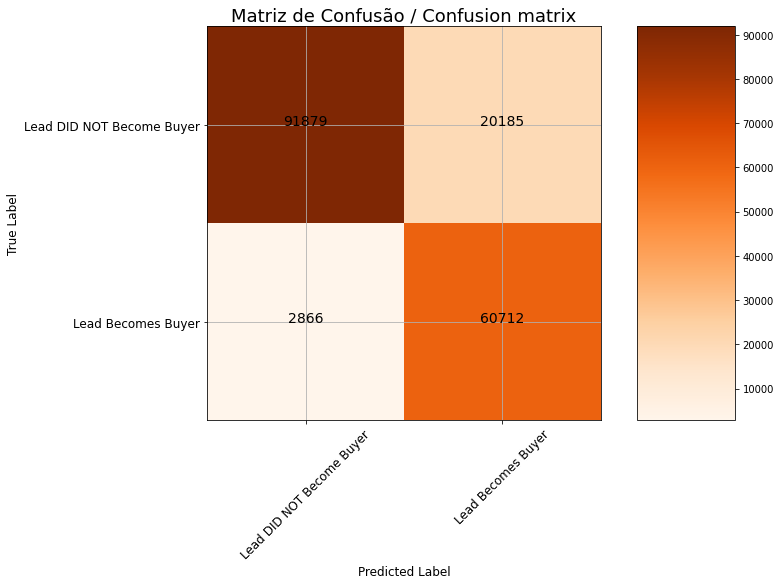

In [122]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 18)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, size = 12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 14,
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True Label', size = 12)
    plt.xlabel('Predicted Label', size = 12)

# Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
plot_confusion_matrix(cm, classes = ['Lead DID NOT Become Buyer', 'Lead Becomes Buyer'], title = 'Matriz de Confusão / Confusion matrix')

## Resultado final com métricas de acertividade do algoritmo / <i>Final result with algorithm accuracy metrics</i>

<b>O modelo escolhido apresentou um F1 score de 0,84 para os dados de teste (dados não vistos pelo modelo em seu treino) / <i>The chosen model presented an F1 score of 0.84 for the test data (data not seen by the model in its training).</i></b>

Análise da matriz de confusão apresentada:
- A matriz de confusão acima mostra que <b>o modelo identificou 60.712 dos 63.578 leads que se tornaram compradores, que corresponde a 95,5%</b>.
- A matriz de confusão acima mostra também que <b>o modelo identificou incorretamente 20.185 dos 112.064 leads que não se tornaram compradores, também chamado de falsos positivos, que corresponde a 18,0%</b>.

<i>Analysis of the presented confusion matrix:</i>
<i>
- The confusion matrix above shows that <b>the model identified 60,712 of the 63,578 leads that became buyers, which corresponds to 95.5%</b>.
- The confusion matrix above also shows that <b>the model incorrectly identified 20,185 of the 112,064 leads that did not become buyers, also called false positives, which corresponds to 18.0%</b>.
</i>

## Fim / <i>End</i>